In [200]:
import pandas as pd
import seaborn as sns
import string as str

In [ ]:
# [margin(em),nasales(s,ret),manufacture(capacity pelnalty),transportation(distcost),innovation,category]

### Sales and Return

In [33]:
nasales=pd.read_csv('sales2018.csv.gz')

In [34]:
margin=pd.read_csv('estimated_margins.csv')
#swsales=pd.read_csv('sales2018_SOUTHWEST_deepdive.csv.gz')

In [35]:
nasales.head()
# sales: total monetary amount sold for this item from this region to this chain during this period, in dollars.
# (Certain values are negative, but you should view this as error from the data sanitization.)

,sales_period,region,chain_id,BDC,BDC_description,GTIN,sales,returns
0,1,SOUTHWEST,6.0,2015006,LAY'S XL HON BBQ,28400200684,40.656,0.000
1,1,SOUTHWEST,6.0,2015009,LAY'S XL KCM,28400199612,269.104,1.936
2,1,SOUTHWEST,6.0,2015011,LAY'S XL REG,28400199148,425.920,3.872
3,1,SOUTHWEST,6.0,2015014,LAY'S XL REG WAVY,28400043809,7.744,0.000
4,1,SOUTHWEST,6.0,2015014,LAY'S XL REG WAVY,28400199544,114.224,5.808


In [31]:
len(nasales[nasales["region"]=="SOUTHWEST"]['BDC'].unique())

1036

In [37]:
nasales['sales_period'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int64)

In [58]:
nasales[(nasales["region"]=="SOUTHWEST")&(nasales['BDC']==1003011)]

,sales_period,region,chain_id,BDC,BDC_description,GTIN,sales,returns
54141,1,SOUTHWEST,NaN,1003011,FRITOS LVL REG,28400381611,11.64,0.00
54961,2,SOUTHWEST,13.0,1003011,FRITOS LVL REG,28400381611,0.00,1.94
94289,2,SOUTHWEST,13539.0,1003011,FRITOS LVL REG,28400381611,-18.43,0.00
95267,2,SOUTHWEST,13604.0,1003011,FRITOS LVL REG,28400381611,0.00,0.97


In [104]:
nasales[(nasales["region"]=="SOUTHWEST")&(nasales['sales']==0)].head()

,sales_period,region,chain_id,BDC,BDC_description,GTIN,sales,returns
5,1,SOUTHWEST,6.0,2015020,LB DUAF XL BAC MAC,28400439381,0.0,1.9360
15,1,SOUTHWEST,6.0,2015334,LAY XL CHZ GAR BRD,28400212083,0.0,13.5520
59,1,SOUTHWEST,6.0,14015674,ORGNC TO XL SCPS REG,28400333948,0.0,0.0000
93,1,SOUTHWEST,6.0,20016517,TOSTIT XXL FTBL SH,28400001809,0.0,27.0000
109,1,SOUTHWEST,6.0,1021097,FRITOS SUPER SCOOPS,28400337281,0.0,2.7892


In [52]:
sw_sales = nasales[nasales["region"]=="SOUTHWEST"]\
.groupby(['BDC']).agg({'sales':'sum','returns':'sum'}).reset_index()

In [55]:
#sw_sales['ret_rate'] = sw_sales['returns']/sw_sales['sales']

In [76]:
sw_sales.head() 
# returns: total monetary amount returned that period because of item expiration. (Fritolay calls these stale items.)

,BDC,sales,returns,ret_rate
0,1003007,6503.85,31.04,0.004773
1,1003011,-6.79,2.91,-0.428571
2,1005006,162664.58,718.54,0.004417
3,1005007,1881.45,72.15,0.038348
4,1005011,321341.30,2232.58,0.006948


In [78]:
sw_sales = sw_sales.drop(columns=['ret_rate']) ## negative sales?

In [80]:
sw_sales[sw_sales['sales']<0].count() # 57 negative sales
# Certain values are negative, but you should view this as error from the data sanitization.

BDC        57
sales      57
returns    57
dtype: int64

In [83]:
sw_sales = sw_sales[sw_sales['sales']>=0].reset_index() # drop negative sales

In [116]:
len(sw_sales)

979

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BE02A2C630>]],
      dtype=object)

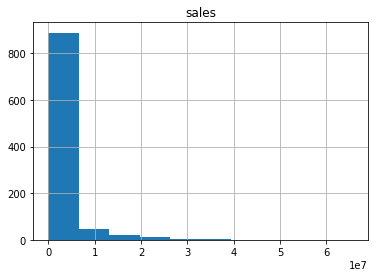

In [87]:
sw_sales.hist(column='sales')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BE255442E8>]],
      dtype=object)

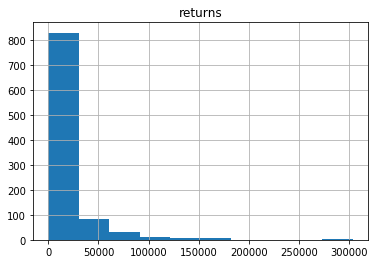

In [88]:
sw_sales.hist(column='returns')

### Margin

In [123]:
margin = margin.groupby(['BDC']).agg({'estimated_margins':'mean'}).reset_index()

In [135]:
margin.head()
# A very rough estimate of how much profit margins FritoLay has for each product 
# (which have been altered to product company secrets). 
# This represents a national average does not account for differential transportation cost in each region.

,BDC,estimated_margins
0,1003007,0.15
1,1003011,0.15
2,1005006,0.15
3,1005007,0.15
4,1005011,0.15


In [127]:
len(margin['BDC'].unique()) == len(margin)

True

In [140]:
sales_m = pd.merge(sw_sales, margin,how='left',on=['BDC'])

In [141]:
sales_m.head()

,index,BDC,sales,returns,estimated_margins
0,0,1003007,6503.85,31.04,0.15
1,2,1005006,162664.58,718.54,0.15
2,3,1005007,1881.45,72.15,0.15
3,4,1005011,321341.30,2232.58,0.15
4,5,1005182,959710.44,6415.80,0.15


In [142]:
len(sales_m['BDC'])

979

In [131]:
sales_m[sales_m['sales']==0]['sales'].count() # 16 sales with 0

16

In [133]:
sales_m.isna().sum() ## 34 BDC without estimated margin

index                 0
BDC                   0
sales                 0
returns               0
estimated_margins    34
dtype: int64

In [155]:
sales_m = sales_m.dropna()

In [156]:
len(sales_m) # drop 34 BDC wiht NA em

945

### Manufacturing Capacity

In [144]:
manufacture=pd.read_csv('manufacturing_platform_capacity.csv')

In [146]:
manufacture = manufacture.groupby(['BDC']).agg({'platform_capacity':'mean'}).reset_index()

In [148]:
manufacture.head()

,BDC,platform_capacity
0,1005006,0.857131
1,1005007,0.857131
2,1005011,0.857131
3,1005182,0.850000
4,1009007,0.857131


In [149]:
len(manufacture['BDC'].unique()) == len(manufacture)

True

In [157]:
sales_em_manu = pd.merge(sales_m, manufacture[['BDC','platform_capacity']],on=['BDC'],how='left')

In [158]:
sales_em_manu.head()

,index,BDC,sales,returns,estimated_margins,platform_capacity
0,0,1003007,6503.85,31.04,0.15,NaN
1,2,1005006,162664.58,718.54,0.15,0.857131
2,3,1005007,1881.45,72.15,0.15,0.857131
3,4,1005011,321341.30,2232.58,0.15,0.857131
4,5,1005182,959710.44,6415.80,0.15,0.850000


In [159]:
sales_em_manu.isna().sum() ## 97 without manufacture

index                 0
BDC                   0
sales                 0
returns               0
estimated_margins     0
platform_capacity    97
dtype: int64

In [167]:
sales_em_manu = sales_em_manu.dropna()

In [168]:
len(sales_em_manu)

848

### transportation

In [160]:
transportation=pd.read_excel('distribution_cost_cleaned.xlsx',sheet_name = 'cost_calculations')

In [164]:
transportation.head()
# This Excel workbook contains data regarding the cost of transportation of various products from one warehouse to another.
# The first worksheet ("cost_calculations") combines information all of the other worksheets 
# and illustrate the relationship.

,BDC,product_description,department,shape,flavor,product_category,source_LMSID,source_warehouse,source_region,destination_LMSID,...,destination_region,destination_zone,cases_ordered,standard_cases_ordered,transportation_cost_per_standard_case,source_cost_per_case,destination_cost_per_case,total_transportation_cost,total_source_cost,total_destination_cost
0,1003006,LVL Fritos Flavor Twist Honey BBQ,FRIED CORN CHIPS,FRITOS TWIST,FCC-TW HONEY BBQ,FRITOS,6360,KILLINGLY PLANT,NORTHEAST,6360,...,NORTHEAST,Plant to Plant,0.0,0.0000,0.000000,0.324432,0.324432,0.000000,0.000000,0.000000
1,1003006,LVL Fritos Flavor Twist Honey BBQ,FRIED CORN CHIPS,FRITOS TWIST,FCC-TW HONEY BBQ,FRITOS,4350,CUCAMONGA PLANT,SOUTHWEST,4350,...,SOUTHWEST,Plant to Plant,0.0,0.0000,0.000000,0.483292,0.483292,0.000000,0.000000,0.000000
2,1003006,LVL Fritos Flavor Twist Honey BBQ,FRIED CORN CHIPS,FRITOS TWIST,FCC-TW HONEY BBQ,FRITOS,4350,CUCAMONGA PLANT,SOUTHWEST,34319,...,SOUTHWEST,Plant to Plant,6776.1,4302.8235,0.471612,0.483292,0.306995,2029.263604,3274.833068,2080.228744
3,1005006,SVL-R Fritos Honey BBQ Twists,FRIED CORN CHIPS,FRITOS TWIST,FCC-TW HONEY BBQ,FRITOS,7310,CHARLOTTE PLANT,CAROLINAS,7310,...,CAROLINAS,Plant to Plant,0.0,0.0000,0.000000,0.392006,0.392006,0.000000,0.000000,0.000000
4,1005006,SVL-R Fritos Honey BBQ Twists,FRIED CORN CHIPS,FRITOS TWIST,FCC-TW HONEY BBQ,FRITOS,7310,CHARLOTTE PLANT,CAROLINAS,3942,...,CAROLINAS,CHESAPEAKE,1623.6,1030.9860,0.389854,0.392006,0.400000,401.934210,636.460831,649.440000


In [165]:
sw_tr = transportation[transportation['destination_region']=='SOUTHWEST']

In [166]:
len(sw_tr['BDC'].unique())

832

In [169]:
sw_tr[sw_tr['BDC']==1003006]

,BDC,product_description,department,shape,flavor,product_category,source_LMSID,source_warehouse,source_region,destination_LMSID,...,destination_region,destination_zone,cases_ordered,standard_cases_ordered,transportation_cost_per_standard_case,source_cost_per_case,destination_cost_per_case,total_transportation_cost,total_source_cost,total_destination_cost
1,1003006,LVL Fritos Flavor Twist Honey BBQ,FRIED CORN CHIPS,FRITOS TWIST,FCC-TW HONEY BBQ,FRITOS,4350,CUCAMONGA PLANT,SOUTHWEST,4350,...,SOUTHWEST,Plant to Plant,0.0,0.0000,0.000000,0.483292,0.483292,0.000000,0.000000,0.000000
2,1003006,LVL Fritos Flavor Twist Honey BBQ,FRIED CORN CHIPS,FRITOS TWIST,FCC-TW HONEY BBQ,FRITOS,4350,CUCAMONGA PLANT,SOUTHWEST,34319,...,SOUTHWEST,Plant to Plant,6776.1,4302.8235,0.471612,0.483292,0.306995,2029.263604,3274.833068,2080.228744


In [170]:
sw_tr = sw_tr.groupby(['BDC']).agg({'total_transportation_cost':'sum',\
                                    'total_source_cost':'sum',\
                                    'total_destination_cost':'sum'}).reset_index()

In [173]:
sw_tr['total_distribution_cost'] = sw_tr['total_transportation_cost']+\
                                   sw_tr['total_source_cost']+\
                                   sw_tr['total_destination_cost']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BE25DD7A90>]],
      dtype=object)

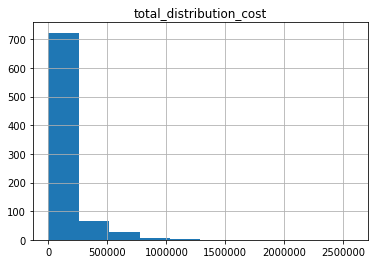

In [175]:
sw_tr.hist(column='total_distribution_cost') # total for 2018

In [178]:
simple = pd.merge(sales_em_manu, sw_tr[['BDC','total_distribution_cost']],on=['BDC'],how='left')

In [180]:
simple.isna().sum() # 369 BDC without distribution cost

index                        0
BDC                          0
sales                        0
returns                      0
estimated_margins            0
platform_capacity            0
total_distribution_cost    369
dtype: int64

In [181]:
simple = simple.dropna()

In [182]:
len(simple)

479

In [192]:
simple['profit'] = (simple['sales']-simple['returns']-simple['total_distribution_cost'])*simple['estimated_margins']

In [193]:
simple[simple['profit']<0]

,index,BDC,sales,returns,estimated_margins,platform_capacity,total_distribution_cost,profit
192,232,6015634,11597.5200,93.1040,0.08,0.884683,25661.244336,-1132.546267
250,301,10045017,637.0272,0.0000,0.10,0.916664,3608.473917,-297.144672
425,503,16014009,2322.2320,0.0000,0.08,0.916664,14172.781472,-948.043958
426,504,16014011,2240.9200,0.0000,0.08,0.916664,40204.561867,-3037.091349
427,505,16014016,2270.9280,0.0000,0.08,0.916664,29243.448710,-2157.801657
428,506,16014041,2484.8560,0.0000,0.08,0.916664,34506.440661,-2561.726773
627,733,85004866,0.0000,11.4312,0.13,0.916664,4900.427447,-638.541624
842,1009,186097022,2280.9600,0.0000,0.08,0.700000,4467.765353,-174.944428


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BE21A6AFD0>]],
      dtype=object)

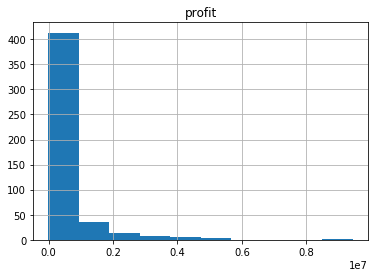

In [194]:
simple.hist(column='profit')

In [196]:
simple = simple.drop(columns=['index'])

In [199]:
simple.to_csv('simple_input.csv',index=False)